# Sentiment Analysis on twitter reviews of self driving cars
## This is supervised learning model as we have labels of sentiments

Fine-grained Sentiment Analysis
Sometimes you may be also interested in being more precise about the level of polarity of the opinion, so instead of just talking about positive, neutral, or negative opinions you could consider the following categories:

Very positive
Positive
Neutral
Negative
Very negative
This is usually referred to as fine-grained sentiment analysis. This could be, for example, mapped onto a 5-star rating in a review, e.g.: Very Positive = 5 stars and Very Negative = 1 star.

In [1]:
# Importing dependencies

import pandas as pd
import numpy as np
import nltk
import re
import spellings
import codecs
import unidecode
import spacy
import matplotlib.pyplot as plt
import text_normalizer as tn
import model_evaluation_utils as meu
import warnings 
warnings.filterwarnings("ignore")
from collections import Counter
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_predict

from sklearn.metrics import precision_score, recall_score, f1_score
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

np.set_printoptions(precision=2, linewidth=80)

Using TensorFlow backend.


In [2]:
dataset_raw = pd.read_csv(r'Twitter_sentiment_selfdrive_DFE_raw.csv',encoding = "ISO-8859-1")
dataset_raw.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,sentiment_gold,sentiment_gold_reason,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,724227031,True,golden,236,NaN,5,0.7579,10001,5\r4,Author is excited about the development of the...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,724227032,True,golden,231,NaN,5,0.8775,10002,5\r4,Author is excited that driverless cars will be...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,724227033,True,golden,233,NaN,2,0.6805,10003,2\r1,The author is skeptical of the safety and reli...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,724227034,True,golden,240,NaN,2,0.8820,10004,2\r1,The author is skeptical of the project's value.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,724227035,True,golden,240,NaN,3,1.0000,10005,3,Author is making an observation without expres...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It seems like we have lot of cleaning work to be done! We should have 11 columns but due to decoding errors and missing commas in csv format, makes it difficult to clean data. I did manual cleaning on csv which took me exactly 2 hours of cleaning to make it better. NOt yet there! we have to clean it more to generate more accuarte model decision making.

In [3]:
dataset = pd.read_csv(r'Twitter_sentiment_selfdrive_DFE_uns.csv',encoding = "ISO-8859-1")
reviews = np.array(dataset['text'])
dataset.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,sentiment_gold,sentiment_gold_reason,text
0,724227031,True,golden,236,NaN,positive,0.7579,10001,5\r4,Author is excited about the development of the...,Two places I'd invest all my money if I could:...
1,724227032,True,golden,231,NaN,positive,0.8775,10002,5\r4,Author is excited that driverless cars will be...,Awesome! Google driverless cars will help the ...
2,724227033,True,golden,233,NaN,negative,0.6805,10003,2\r1,The author is skeptical of the safety and reli...,If Google maps can't keep up with road constru...
3,724227034,True,golden,240,NaN,negative,0.8820,10004,2\r1,The author is skeptical of the project's value.,Autonomous cars seem way overhyped given the t...
4,724227035,True,golden,240,NaN,neutral,1.0000,10005,3,Author is making an observation without expres...,Just saw Google self-driving car on I-34. It w...


## Pre-procesing on whole dataset to remove unwanted columns & missing values

As we see from above summary that we have many redundant features we need to remove. 

In [4]:
dataset = dataset.drop(['our_id','_last_judgment_at', '_unit_state'], axis=1)
dataset = dataset[~dataset['text'].isnull()]

# Data Cleaning
Below are the steps I took to clean the tweets:

1. Decoding: unicode_escape for extra “\” before unicode character, then unidecode
2. Apostrophe handled: there are two characters people use for contraction. “’”(apostrophe) and “‘“(single quote). If these two symbols are both used for contraction, it will be difficult to detect and properly map the right expanded form. So any “’”(apostrophe) is changed to “‘“(single quote)
3. Contraction check: check if there’s any contracted form, and replace it with its original form
4. Parsing: done with Spacy
5. Filtering punctuation, white space, numbers, URL using Spacy methods while keeping the text content of hashtag intact
6. Removed @mention
7. Lemmatize: lemmatized each token using Spacy method ‘.lemma_’. Pronouns are kept as they are since Spacy lemmatizer transforms every pronoun to “-PRON-”
8. Special character removal
9. Single syllable token removal
10. Spell correction: it is a simple spell correction dealing with repeated characters such as “sooooo goooood”. If the same character is repeated more than two times, it shortens the repetition to two. For example “sooooo goooood” will be transformed as “soo good”. This is not a perfect solution since even after correction, in case of “soo”, it is not a correct spelling. But at least it will help to reduce feature space by making “sooo”, “soooo”, “sooooo” to the same word “soo”

In [5]:
nlp = spacy.load('en_core_web_md')
stop_words = nltk.corpus.stopwords.words('english')
def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([spellings.contraction_mapping[t] if t in spellings.contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
      
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    if sc_removed in stop_words:
                        pass
                    else:
                        final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected


## Applying above cleaner & saving cleaned text as new column

First we clean the data to eliminate unwanted characters, spaces, urls and stuff

In [6]:
dataset['clean_text'] = [spacy_cleaner(t) for t in dataset.text]

## Data Exploration

We need to visualize data to make judgement on feature engineering techniques to use and do we need feature selection or do we need to balance data, which model best fits our data and how we can get better performance of prediction model. Do we need deep learning?

In [7]:
# Describe Numeric columns
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment:confidence,6947.0,0.777805,0.204332,0.248,0.63275,0.7536,1.0,1.0


By applying nunique we would have idea of how many sentiments do we have. In most sentiment analysis, positive, negative and neutral are the sentiments. However, for our data we are dealing with fine-grain sentiment analysis as we have 5 sentiments and not revelent which can also be considered sentiment. So we have 6 sentiments.

In [8]:
# Describing categorical columns
dataset['sentiment'].nunique()

3

In [9]:
# plt.figure(figsize = (20, 12))
# cplt.scatter(dataset[sentiments == 'positive'], c = 'g', label = 'Positive Sentiments')
#plt.scatter(dataset[sentiments == 'negative'], c = 'r', label = 'Negative Sentiments')
#plt.scatter(dataset[sentiments == 'neutral'], c = 'b', label = 'Neutral Sentiments')
#plt.xlabel('Sentiments', fontsize = 16)
#plt.ylabel('features', fontsize = 16)
#plt.title('Plot between Experience and Age', fontsize = 16)
#plt.legend(fontsize = 16)

## Is our dataset balanced??

Lets check by grouping rows by sentiment.
After executing this cell, we got that our dataset is imbalanced maximum sentiments are rated 3.

So This data is imbalanced data. We will over sample data using SMOTE technique after exploration.

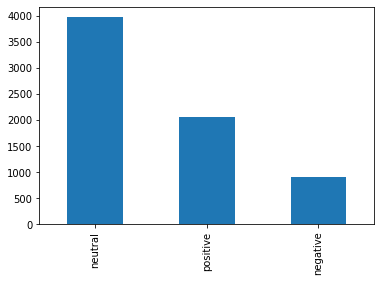

In [10]:
dataset['sentiment'].value_counts().plot.bar()

In [11]:
# size info, including memory consumption
dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6947 entries, 0 to 6946
Data columns (total 9 columns):
_unit_id                 6947 non-null object
_golden                  6947 non-null bool
_trusted_judgments       6947 non-null object
sentiment                6947 non-null object
sentiment:confidence     6947 non-null float64
sentiment_gold           66 non-null object
sentiment_gold_reason    66 non-null object
text                     6947 non-null object
clean_text               6947 non-null object
dtypes: bool(1), float64(1), object(7)
memory usage: 3.9 MB


## Know important words from dataset

In [12]:
def my_tokenizer(clean_text):
    clean_text = re.sub(r'[^a-zA-Z\s]', '', clean_text, re.I|re.A)
    clean_text = clean_text.lower()
    return clean_text.split() if clean_text != None else []

# transform list of documents into a single list of tokens
tokens = dataset.clean_text.map(my_tokenizer).sum()
counter = Counter(tokens)
dataset['text_token'] = [my_tokenizer(t) for t in dataset.clean_text]
counter.most_common(20)

[('car', 6766),
 ('drive', 4253),
 ('self', 4033),
 ('google', 2933),
 ('driverless', 1896),
 ('i', 1509),
 ('it', 797),
 ('you', 593),
 ('see', 583),
 ('we', 496),
 ('my', 436),
 ('get', 416),
 ('autonomous', 399),
 ('driving', 382),
 ('vehicle', 352),
 ('go', 334),
 ('future', 327),
 ('driver', 317),
 ('would', 297),
 ('make', 292)]

In [13]:
dataset.head(5)

,_unit_id,_golden,_trusted_judgments,sentiment,sentiment:confidence,sentiment_gold,sentiment_gold_reason,text,clean_text,text_token
0,724227031,True,236,positive,0.7579,5\r4,Author is excited about the development of the...,Two places I'd invest all my money if I could:...,place I would invest my money I could printing...,"[place, i, would, invest, my, money, i, could,..."
1,724227032,True,231,positive,0.8775,5\r4,Author is excited that driverless cars will be...,Awesome! Google driverless cars will help the ...,awesome Google driverless car help blind trave...,"[awesome, google, driverless, car, help, blind..."
2,724227033,True,233,negative,0.6805,2\r1,The author is skeptical of the safety and reli...,If Google maps can't keep up with road constru...,Google map keep road construction I suppose tr...,"[google, map, keep, road, construction, i, sup..."
3,724227034,True,240,negative,0.8820,2\r1,The author is skeptical of the project's value.,Autonomous cars seem way overhyped given the t...,autonomous car seem way overhype give technolo...,"[autonomous, car, seem, way, overhype, give, t..."
4,724227035,True,240,neutral,1.0000,3,Author is making an observation without expres...,Just saw Google self-driving car on I-34. It w...,see Google self drive car It paint green blue,"[see, google, self, drive, car, it, paint, gre..."


We created a new column named text_token which contains text in form of list of words, later during feature engineering, we will use this column to deploy word2vec or bag of words model

## Generate frequency dataframe
After cleaning data little bit & tokenizing, we generate frequency dataframe to see which words affect our model the most.

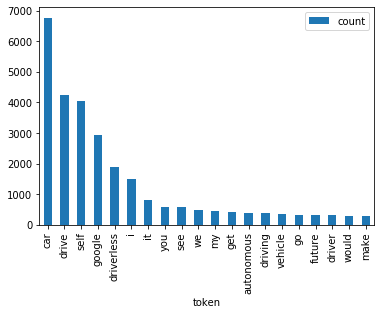

In [14]:
# convert list of tuples into data frame

freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])
# create bar plot
freq_df.plot(kind='bar', x='token');

In [15]:
def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

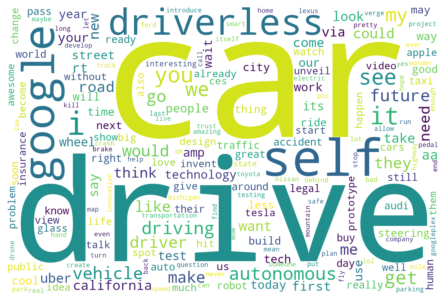

In [16]:
# create wordcloud
wordcloud(counter)

## Split data into test & train

We have to split data into test/train before we apply feature engineering and normalize it.

In [17]:
# take a peek at the data
reviews = np.array(dataset['clean_text'])
sentiments = np.array(dataset['sentiment'])

# build train and test datasets
train_reviews = reviews[:5800]
train_sentiments = sentiments[:5800]
test_reviews = reviews[5800:]
test_sentiments = sentiments[5800:]



In [18]:
# normalize datasets
norm_train_reviews = tn.normalize_corpus(train_reviews)
norm_test_reviews = tn.normalize_corpus(test_reviews)
norm_full_reviews = tn.normalize_corpus(reviews)

Now we have data tokenized and normalized! We can perform feature engineering on top of it get model better.

## Feature Engineering 


You may still consider to use BoW rather than Word Embedding in the following situations:
Building a baseline model. By using scikit-learn, there is just a few lines of code to build model. Later on, can using Deep Learning to bit it.
If your dataset is small and context is domain specific, BoW may work better than Word Embedding. Context is very domain specific which means that you cannot find corresponding Vector from pre-trained word embedding models (GloVe, fastText etc).

Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space.

In [19]:




from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(norm_train_reviews)
# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2), sublinear_tf=True)
tv_train_features = tv.fit_transform(norm_train_reviews)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_train_features)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,5790,5791,5792,5793,5794,5795,5796,5797,5798,5799
0,1.000000,0.001792,0.001550,0.001197,0.020826,0.002036,0.032735,0.001407,0.002248,0.000000,...,0.016203,0.027492,0.018796,0.014515,0.014549,0.014549,0.015165,0.014711,0.031539,0.026525
1,0.001792,1.000000,0.020441,0.001266,0.008340,0.020679,0.000000,0.014291,0.022832,0.000000,...,0.002663,0.002850,0.003089,0.001505,0.001508,0.001508,0.108065,0.001525,0.003270,0.007350
2,0.001550,0.020441,1.000000,0.001095,0.007213,0.017886,0.000000,0.012360,0.019748,0.013977,...,0.002303,0.032620,0.002672,0.021224,0.001305,0.001305,0.055541,0.001319,0.002828,0.006357
3,0.001197,0.001266,0.001095,1.000000,0.001442,0.001438,0.018830,0.000994,0.001587,0.000000,...,0.001779,0.001903,0.002063,0.001005,0.001007,0.001007,0.001050,0.020711,0.002184,0.001271
4,0.020826,0.008340,0.007213,0.001442,1.000000,0.002452,0.000000,0.001695,0.002707,0.000000,...,0.036809,0.033114,0.022639,0.017483,0.017524,0.017524,0.036792,0.017719,0.037988,0.054370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5795,0.014549,0.001508,0.001305,0.001007,0.017524,0.001713,0.000000,0.001184,0.036023,0.018282,...,0.013634,0.023134,0.015816,0.012214,1.000000,1.000000,0.012761,0.012379,0.026539,0.049644
5796,0.015165,0.108065,0.055541,0.001050,0.036792,0.001786,0.000000,0.001234,0.001971,0.013404,...,0.014211,0.053031,0.016486,0.012731,0.012761,0.012761,1.000000,0.012902,0.027663,0.039592
5797,0.014711,0.001525,0.001319,0.020711,0.017719,0.001732,0.000000,0.001197,0.001912,0.000000,...,0.013785,0.023390,0.038219,0.012349,0.012379,0.012379,0.012902,1.000000,0.026833,0.022567
5798,0.031539,0.003270,0.002828,0.002184,0.037988,0.003713,0.000000,0.002566,0.004100,0.000000,...,0.077268,0.050148,0.034285,0.026477,0.026539,0.026539,0.027663,0.026833,1.000000,0.048383


In [21]:
#from scipy.cluster.hierarchy import dendrogram, linkage

# Z = linkage(similarity_matrix, 'ward')
# pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
#                         'Distance', 'Cluster Size'], dtype='object')

In [22]:
#plt.figure(figsize=(8, 3))
#plt.title('Hierarchical Clustering Dendrogram')
#plt.xlabel('Data point')
#plt.ylabel('Distance')
#dendrogram(Z)
#plt.axhline(y=40, c='k', ls='--', lw=0.5)

In [23]:
#from scipy.cluster.hierarchy import fcluster
#max_dist = 40

#cluster_labels = fcluster(Z, max_dist, criterion='distance')
#cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
#pd.concat([dataset, cluster_labels], axis=1)

In [24]:
#from sklearn.decomposition import LatentDirichletAllocation
#cv_train_features = cv_train_features.toarray()
#lda = LatentDirichletAllocation(n_components=3, max_iter=6000, random_state=0)
#dt_matrix = lda.fit_transform(cv_train_features)
#train_features = pd.DataFrame(dt_matrix, columns=['T1', 'T2', 'T3'])

In [25]:
#dtest_matrix = lda.fit_transform(cv_test_features)
#test_features = pd.DataFrame(dtest_matrix, columns=['T1', 'T2', 'T3'])

In [26]:

# transform test reviews into features
cv_test_features = cv.transform(norm_test_reviews)
tv_test_features = tv.transform(norm_test_reviews)


In [27]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (5800, 33293)  Test features shape: (1147, 33293)
TFIDF model:> Train features shape: (5800, 33293)  Test features shape: (1147, 33293)


In [28]:
cv_full_features = cv.transform(norm_full_reviews)
tv_full_features = tv.transform(norm_full_reviews)

In [29]:
print('TFIDF model:> full features shape:', tv_full_features.shape)

TFIDF model:> full features shape: (6947, 33293)


In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions

#array = dataset.values
X_select = tv_train_features
Y_select = train_sentiments
# feature extraction
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X_select, Y_select)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X_select)
# summarize selected features
print(features)

[0.119 0.06  0.355 ... 0.355 0.355 3.682]
  (1, 1)	0.07366440198816679
  (2, 1)	0.0637139405195462
  (4, 1)	0.08390759890540901
  (7, 3)	0.13761900282069425
  (10, 1)	0.04935562898788378
  (12, 0)	0.1888940983507088
  (16, 1)	0.053714160644099826
  (36, 1)	0.062498430800249645
  (40, 1)	0.059798056069518636
  (43, 1)	0.05619449824490782
  (61, 1)	0.0695374281174824
  (64, 1)	0.05363516122551311
  (67, 1)	0.05325847084954077
  (73, 1)	0.13480829822381626
  (74, 2)	0.12666766663919135
  (80, 1)	0.05546785544271202
  (86, 2)	0.1400988101492303
  (86, 1)	0.05470617887685334
  (93, 0)	0.14979968201064656
  (93, 1)	0.05830808101675218
  (97, 1)	0.07954559426192984
  (106, 0)	0.1649504638765081
  (107, 1)	0.0727158530723636
  (108, 1)	0.07855892100949925
  (112, 1)	0.06875847180981287
  :	:
  (5733, 0)	0.1481684045354885
  (5737, 3)	0.1391897024938245
  (5739, 2)	0.20961709435464013
  (5741, 0)	0.18032934620771204
  (5743, 1)	0.06717520715829615
  (5745, 1)	0.08749344034768175
  (5746, 1)	0.0

In [31]:
#array = dataset.values
X_test_select = tv_test_features
Y_test_select = test_sentiments
# feature extraction
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X_test_select, Y_test_select)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
test_features = fit.transform(X_test_select)
# summarize selected features
print(test_features)

[0.209 0.771   nan ...   nan   nan   nan]
  (43, 2)	0.286852831195934
  (140, 3)	0.3133174946588314
  (143, 3)	0.28103368224323605
  (143, 2)	0.22686185301462405
  (155, 2)	0.24770776864969665
  (324, 3)	0.40336897551236434
  (360, 2)	0.3377838778119919
  (379, 1)	0.35959443061340834
  (380, 1)	0.3049188052843634
  (381, 1)	0.3049188052843634
  (396, 2)	0.23811945740641327
  (414, 2)	0.3422462468340981
  (418, 0)	0.22882191423627218
  (419, 2)	0.25429427228926754
  (425, 2)	0.45759620241569604
  (427, 0)	0.36800712360863896
  (485, 1)	0.3691407971637688
  (487, 1)	0.30763351273465206
  (526, 3)	0.371616935113735
  (529, 0)	0.35721392226565396
  (545, 1)	0.3691407971637688
  (606, 0)	0.25228437671260967
  (614, 2)	0.3381573437462018
  (727, 3)	0.3000405251890063
  (877, 2)	0.26334911717382725
  (877, 0)	0.2558722151832128
  (878, 0)	0.39064100608181973
  (879, 2)	0.3363377568320673
  (879, 0)	0.326788590802714
  (1014, 2)	0.28600509878981273
  (1019, 2)	0.3258436383978426
  (1122, 2)	0.

In [32]:
#dtfull_matrix = lda.fit_transform(tv_full_features)
#full_features = pd.DataFrame(dfull_matrix, columns=['T1', 'T2', 'T3'])

In [33]:
from sklearn.linear_model import SGDClassifier

lr = LogisticRegression(penalty='l2', max_iter=100, C=1)
svm = SGDClassifier(loss='hinge', max_iter=100)

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_new = SelectKBest(chi2, k=2).fit_transform(cv_train_features, train_sentiments)
X_new.shape

(5800, 2)

In [35]:
# Logistic Regression model on topic model features
lr_bow_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=cv_train_features, train_labels=train_sentiments,
                                             test_features=cv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                      classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.6207
Precision: 0.6067
Recall: 0.6207
F1 Score: 0.574

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.61      0.49      0.54       342
    negative       0.54      0.11      0.19       219
     neutral       0.63      0.89      0.74       586

    accuracy                           0.62      1147
   macro avg       0.59      0.50      0.49      1147
weighted avg       0.61      0.62      0.57      1147


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        168       12     162
        negative         50       25     144
        neutral          58        9     519


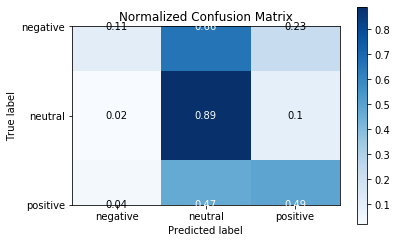

In [36]:
import scikitplot as skplt
import matplotlib.pyplot as plt
y_true = test_sentiments # ground truth labels
y_probas_lr = lr_bow_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(y_true, y_probas_lr, normalize=True)
plt.show()

In [37]:
lr_fs_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=features, train_labels=train_sentiments,
                                             test_features=test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_fs_predictions,
                                      classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.5109
Precision: 0.2898
Recall: 0.5109
F1 Score: 0.3526

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.08      0.01      0.01       342
    negative       0.00      0.00      0.00       219
     neutral       0.52      1.00      0.68       586

    accuracy                           0.51      1147
   macro avg       0.20      0.33      0.23      1147
weighted avg       0.29      0.51      0.35      1147


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive          2        0     340
        negative         21        0     198
        neutral           2        0     584


In [38]:
# Logistic Regression model on TF-IDF features
lr_tfidf_predictions = meu.train_predict_model(classifier=lr, 
                                               train_features=tv_train_features, train_labels=train_sentiments,
                                               test_features=tv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_tfidf_predictions,
                                      classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.5937
Precision: 0.5961
Recall: 0.5937
F1 Score: 0.517

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.60      0.40      0.48       342
    negative       0.60      0.01      0.03       219
     neutral       0.59      0.92      0.72       586

    accuracy                           0.59      1147
   macro avg       0.60      0.45      0.41      1147
weighted avg       0.60      0.59      0.52      1147


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        137        2     203
        negative         46        3     170
        neutral          45        0     541


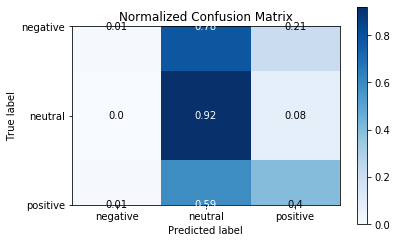

In [39]:
# y_true = test_sentiments # ground truth labels
y_probas_lrtf = lr_tfidf_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(y_true, y_probas_lrtf, normalize=True)
plt.show()

In [40]:

svm_bow_predictions = meu.train_predict_model(classifier=svm, 
                                             train_features=cv_train_features, train_labels=train_sentiments,
                                             test_features=cv_test_features, test_labels=test_sentiments)

meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_bow_predictions,
                                      classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.6181
Precision: 0.6112
Recall: 0.6181
F1 Score: 0.5922

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.57      0.54      0.55       342
    negative       0.59      0.21      0.32       219
     neutral       0.64      0.82      0.72       586

    accuracy                           0.62      1147
   macro avg       0.60      0.52      0.53      1147
weighted avg       0.61      0.62      0.59      1147


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        184       14     144
        negative         50       47     122
        neutral          90       18     478


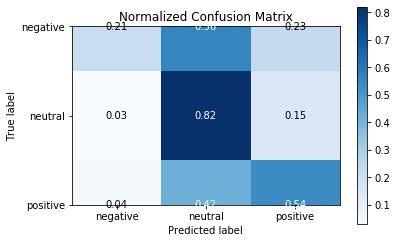

In [41]:
# y_true = test_sentiments # ground truth labels
y_probas_lrtf = svm_bow_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(y_true, y_probas_lrtf, normalize=True)
plt.show()

In [42]:
svm_tfidf_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=tv_train_features, train_labels=train_sentiments,
                                                test_features=tv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions,
                                      classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.6181
Precision: 0.6115
Recall: 0.6181
F1 Score: 0.592

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.55      0.56      0.56       342
    negative       0.59      0.20      0.30       219
     neutral       0.65      0.81      0.72       586

    accuracy                           0.62      1147
   macro avg       0.60      0.52      0.53      1147
weighted avg       0.61      0.62      0.59      1147


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        193       15     134
        negative         56       44     119
        neutral          99       15     472


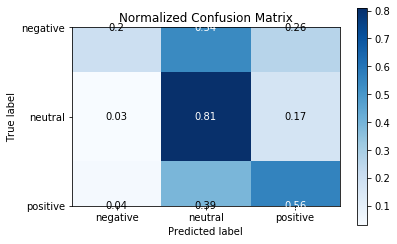

In [43]:
# y_true = test_sentiments # ground truth labels
y_probas_lrtf = svm_tfidf_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(y_true, y_probas_lrtf, normalize=True)
plt.show()

In [44]:
dataset['sentiment'].value_counts()

neutral     3977
positive    2057
negative     913
Name: sentiment, dtype: int64

## Balancing the data

As we came to know from our data exploration, our data is imbalanced and there are more than 50% sentiments at rating 3. We will use SMOTE technique to synthetically create data which is similar to present data with same random modification.

## Balancing the Data using SMOTE

SMOTE is an over-sampling approach in which the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement.

According to the original research paper “SMOTE: Synthetic Minority Over-sampling Technique” (Chawla et al., 2002), “synthetic samples are generated in the following way: Take the difference between the feature vector (sample) under consideration and its nearest neighbour. Multiply this difference by a random number between 0 and 1, and add it to the feature vector under consideration. This causes the selection of a random point along the line segment between two specific features. This approach effectively forces the decision region of the minority class to become more general.” What this means is that when SMOTE creates a new synthetic data, it will choose one data to copy, and look at its k nearest neighbours. Then, on feature space, it will create random values in feature space that is between the original sample and its neighbours.

Reference: https://towardsdatascience.com/yet-another-twitter-sentiment-analysis-part-1-tackling-class-imbalance-4d7a7f717d44

## SMOTE Over sampling

In [45]:
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
sm = SMOTE(random_state=42)


X = tv_train_features
y = train_sentiments
X_res, y_res = sm.fit_resample(X, y)


In [80]:
#array = dataset.values
X_train_select = X_res
Y_train_select = y_res
# feature extraction
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X_train_select, Y_train_select)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features_smote_train = fit.transform(X_train_select)
# summarize selected features
print(features_smote_train)

[0.828 1.433 1.    ... 1.    1.    4.899]
  (0, 2)	0.06205728710393425
  (0, 1)	0.05879516856440702
  (4, 2)	0.07474658276147111
  (4, 1)	0.07081743560129751
  (12, 0)	0.1888940983507088
  (12, 1)	0.06205476699530812
  (13, 2)	0.0686904245755951
  (13, 1)	0.06507962690858203
  (14, 2)	0.07057841212696951
  (14, 1)	0.06686837004433416
  (15, 2)	0.07191509179470054
  (15, 1)	0.06813478548156134
  (16, 2)	0.04784965851034909
  (16, 1)	0.045334381652125604
  (19, 2)	0.046117424616327604
  (19, 1)	0.043693204788860567
  (21, 2)	0.07191509179470054
  (21, 1)	0.06813478548156134
  (22, 2)	0.0633286766188851
  (22, 1)	0.059999725907001776
  (23, 2)	0.04390905309627916
  (23, 1)	0.04160091906653075
  (24, 2)	0.06049271388492273
  (24, 1)	0.05731283908408226
  (29, 1)	0.042721282959845605
  :	:
  (10158, 2)	0.09886031681924146
  (10159, 1)	0.013545348831849206
  (10159, 2)	0.014296882242291503
  (10160, 1)	0.09153030059014305
  (10160, 2)	0.06997374022366079
  (10162, 1)	0.04984062599784971
  (1

## Now we have balanced data

In [46]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({'positive': 3391, 'negative': 3391, 'neutral': 3391})


In [47]:
Xx = tv_test_features
yY = test_sentiments
Xx_res, yY_res = sm.fit_resample(Xx, yY)

In [79]:
#array = dataset.values
X_smote_select = Xx_res
Y_smote_select = yY_res
# feature extraction
test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(X_smote_select, Y_smote_select)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features_smote = fit.transform(X_smote_select)
# summarize selected features
print(features_smote)

[0.586 1.011   nan ...   nan   nan   nan]
  (140, 2)	0.3133174946588314
  (143, 2)	0.28103368224323605
  (324, 2)	0.40336897551236434
  (379, 1)	0.35959443061340834
  (380, 1)	0.3049188052843634
  (381, 1)	0.3049188052843634
  (461, 0)	0.3768289648185507
  (485, 1)	0.3691407971637688
  (487, 1)	0.30763351273465206
  (526, 2)	0.371616935113735
  (527, 0)	0.30933111006944414
  (545, 1)	0.3691407971637688
  (687, 3)	0.47413661446671235
  (687, 0)	0.43750898697067253
  (688, 3)	0.47413661446671235
  (688, 0)	0.43750898697067253
  (689, 3)	0.47413661446671235
  (689, 0)	0.43750898697067253
  (691, 3)	0.4187127451388327
  (691, 0)	0.38636667864903174
  (694, 3)	0.3794223133013474
  (694, 0)	0.35011148023919597
  (696, 3)	0.4187127451388327
  (696, 0)	0.38636667864903174
  (710, 3)	0.392668744422553
  :	:
  (1409, 3)	0.41522537667994186
  (1411, 1)	0.26907001731447683
  (1419, 1)	0.09321877920432381
  (1419, 2)	0.2777728591158548
  (1426, 0)	0.382481136113927
  (1426, 3)	0.41450191053240104
 

In [48]:
lr_smote_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=X_res, train_labels=y_res,
                                             test_features=Xx_res, test_labels=yY_res)
meu.display_model_performance_metrics(true_labels=yY_res, predicted_labels=lr_smote_predictions,
                                      classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.5609
Precision: 0.5781
Recall: 0.5609
F1 Score: 0.5514

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.55      0.67      0.60       586
    negative       0.65      0.36      0.47       586
     neutral       0.53      0.66      0.58       586

    accuracy                           0.56      1758
   macro avg       0.58      0.56      0.55      1758
weighted avg       0.58      0.56      0.55      1758


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        390       47     149
        negative        178      212     196
        neutral         137       65     384


In [81]:
lr_smoteselect_predictions = meu.train_predict_model(classifier=lr, 
                                             train_features=features_smote_train, train_labels=y_res,
                                             test_features=features_smote, test_labels=yY_res)
meu.display_model_performance_metrics(true_labels=yY_res, predicted_labels=lr_smoteselect_predictions,
                                      classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.289
Precision: 0.1009
Recall: 0.289
F1 Score: 0.1496

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00       586
    negative       0.30      0.87      0.45       586
     neutral       0.00      0.00      0.00       586

    accuracy                           0.29      1758
   macro avg       0.10      0.29      0.15      1758
weighted avg       0.10      0.29      0.15      1758


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive          0      586       0
        negative         59      508      19
        neutral           2      584       0


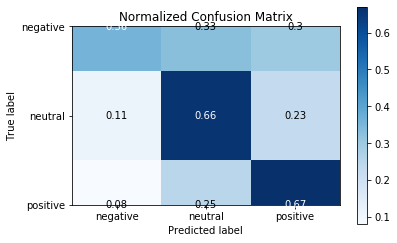

In [49]:
# y_true = test_sentiments # ground truth labels
y_probas_lrtf = lr_smote_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(yY_res, y_probas_lrtf, normalize=True)
plt.show()

In [50]:
svm_smote_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=X_res, train_labels=y_res,
                                                test_features=Xx_res, test_labels=yY_res)
meu.display_model_performance_metrics(true_labels=yY_res, predicted_labels=svm_smote_predictions,
                                      classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.5614
Precision: 0.6067
Recall: 0.5614
F1 Score: 0.5459

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.54      0.67      0.60       586
    negative       0.76      0.31      0.44       586
     neutral       0.52      0.70      0.60       586

    accuracy                           0.56      1758
   macro avg       0.61      0.56      0.55      1758
weighted avg       0.61      0.56      0.55      1758


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        393       24     169
        negative        189      182     215
        neutral         140       34     412


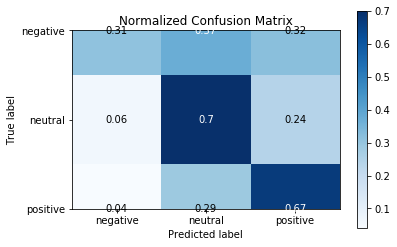

In [51]:
# y_true = test_sentiments # ground truth labels
y_probas_lrtf = svm_smote_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(yY_res, y_probas_lrtf, normalize=True)
plt.show()

In [52]:
# auc = roc_auc_score(yY_res, y_probas_lrtf)

In [53]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)

X_under, y_under = cc.fit_resample(X, y)
Xx_under, yY_under = sm.fit_resample(Xx, yY)

print(sorted(Counter(y_under).items()))
print(sorted(Counter(yY_under).items()))

[('negative', 694), ('neutral', 694), ('positive', 694)]
[('negative', 586), ('neutral', 586), ('positive', 586)]


In [54]:
lr_smote_under_predictions = meu.train_predict_model(classifier=lr,train_features=X_under, train_labels=y_under,test_features=Xx_under, test_labels=yY_under)

meu.display_model_performance_metrics(true_labels=yY_under, predicted_labels=lr_smote_under_predictions,classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.5444
Precision: 0.5494
Recall: 0.5444
F1 Score: 0.5423

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.52      0.61      0.56       586
    negative       0.59      0.45      0.51       586
     neutral       0.54      0.57      0.55       586

    accuracy                           0.54      1758
   macro avg       0.55      0.54      0.54      1758
weighted avg       0.55      0.54      0.54      1758


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        360       87     139
        negative        177      263     146
        neutral         155       97     334


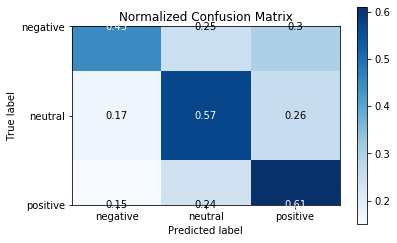

In [55]:
# y_true = test_sentiments # ground truth labels
y_probas_lrtf = lr_smote_under_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(yY_under, y_probas_lrtf, normalize=True)
plt.show()

In [56]:
svm_smote_under_predictions = meu.train_predict_model(classifier=svm,train_features=X_under, train_labels=y_under,test_features=Xx_under, test_labels=yY_under)

meu.display_model_performance_metrics(true_labels=yY_under, predicted_labels=svm_smote_under_predictions,classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.5421
Precision: 0.5519
Recall: 0.5421
F1 Score: 0.5401

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.52      0.59      0.55       586
    negative       0.62      0.44      0.51       586
     neutral       0.52      0.60      0.56       586

    accuracy                           0.54      1758
   macro avg       0.55      0.54      0.54      1758
weighted avg       0.55      0.54      0.54      1758


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        344       71     171
        negative        172      257     157
        neutral         147       87     352


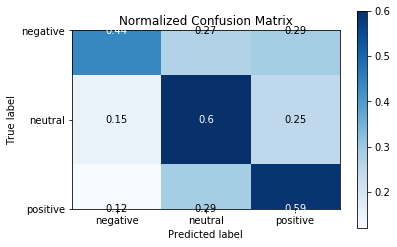

In [57]:
# y_true = test_sentiments # ground truth labels
y_probas_lrtf = svm_smote_under_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(yY_under, y_probas_lrtf, normalize=True)
plt.show()

## Random Over Sampling 

In [58]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()

X_ros, y_ros = ros.fit_sample(X, y)
Xx_ros, yY_ros = ros.fit_resample(Xx, yY)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')
print(Xx_ros.shape[0] - Xx.shape[0], 'new random picked points')

4373 new random picked points
611 new random picked points


In [59]:
lr_random_over_predictions = meu.train_predict_model(classifier=lr,train_features=X_ros, train_labels=y_ros,test_features=Xx_ros, test_labels=yY_ros)

meu.display_model_performance_metrics(true_labels=yY_ros, predicted_labels=lr_random_over_predictions,classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.5404
Precision: 0.5585
Recall: 0.5404
F1 Score: 0.5299

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.58      0.57      0.57       586
    negative       0.61      0.34      0.44       586
     neutral       0.49      0.71      0.58       586

    accuracy                           0.54      1758
   macro avg       0.56      0.54      0.53      1758
weighted avg       0.56      0.54      0.53      1758


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        332       65     189
        negative        139      200     247
        neutral         105       63     418


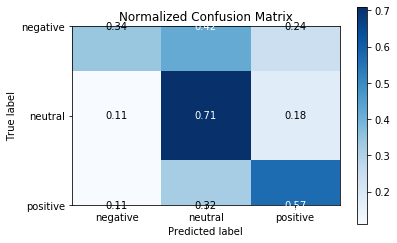

In [60]:
# y_true = test_sentiments # ground truth labels
y_probas_lrtf = lr_random_over_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(yY_ros, y_probas_lrtf, normalize=True)
plt.show()

In [61]:
svm_random_over_predictions = meu.train_predict_model(classifier=svm,train_features=X_ros, train_labels=y_ros,test_features=Xx_ros, test_labels=yY_ros)

meu.display_model_performance_metrics(true_labels=yY_ros, predicted_labels=svm_random_over_predictions,classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.5495
Precision: 0.5918
Recall: 0.5495
F1 Score: 0.5314

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.58      0.58      0.58       586
    negative       0.71      0.30      0.42       586
     neutral       0.49      0.78      0.60       586

    accuracy                           0.55      1758
   macro avg       0.59      0.55      0.53      1758
weighted avg       0.59      0.55      0.53      1758


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        337       40     209
        negative        150      173     263
        neutral          99       31     456


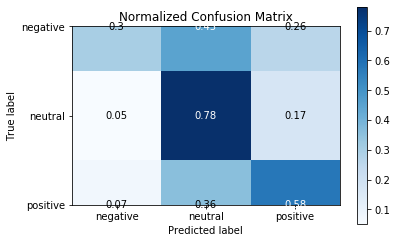

In [62]:
# y_true = test_sentiments # ground truth labels
y_probas_lrtf = svm_random_over_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(yY_ros, y_probas_lrtf, normalize=True)
plt.show()

## Random Under Sampling 

In [63]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()

X_rus, y_rus = rus.fit_sample(X, y)
Xx_rus, yY_rus = sm.fit_resample(Xx, yY)

print(sorted(Counter(y_rus).items()))
print(sorted(Counter(yY_rus).items()))

[('negative', 694), ('neutral', 694), ('positive', 694)]
[('negative', 586), ('neutral', 586), ('positive', 586)]


In [64]:
lr_random_under_predictions = meu.train_predict_model(classifier=lr,train_features=X_rus, train_labels=y_rus,test_features=Xx_rus, test_labels=yY_rus)

meu.display_model_performance_metrics(true_labels=yY_rus, predicted_labels=lr_random_under_predictions,classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.5341
Precision: 0.5341
Recall: 0.5341
F1 Score: 0.534

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.55      0.56      0.56       586
    negative       0.53      0.51      0.52       586
     neutral       0.52      0.53      0.53       586

    accuracy                           0.53      1758
   macro avg       0.53      0.53      0.53      1758
weighted avg       0.53      0.53      0.53      1758


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        330      122     134
        negative        134      297     155
        neutral         131      143     312


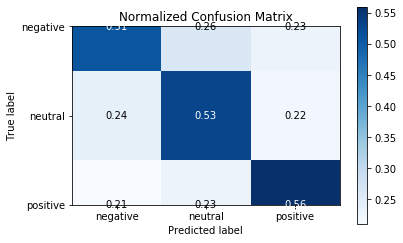

In [65]:
# y_true = test_sentiments # ground truth labels
y_probas_lrtf = lr_random_under_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(yY_rus, y_probas_lrtf, normalize=True)
plt.show()

In [66]:
svm_random_under_predictions = meu.train_predict_model(classifier=svm,train_features=X_rus, train_labels=y_rus,test_features=Xx_rus, test_labels=yY_rus)

meu.display_model_performance_metrics(true_labels=yY_rus, predicted_labels=svm_random_under_predictions,classes=['positive', 'negative', 'neutral'])

Model Performance metrics:
------------------------------
Accuracy: 0.554
Precision: 0.5565
Recall: 0.554
F1 Score: 0.5544

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.58      0.54      0.56       586
    negative       0.58      0.55      0.56       586
     neutral       0.51      0.57      0.54       586

    accuracy                           0.55      1758
   macro avg       0.56      0.55      0.55      1758
weighted avg       0.56      0.55      0.55      1758


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive negative neutral
Actual: positive        318      108     160
        negative        107      321     158
        neutral         123      128     335


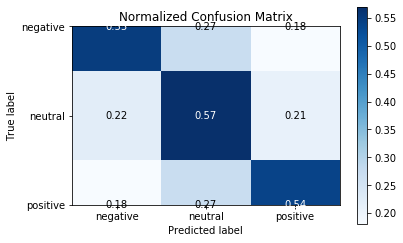

In [67]:
# y_true = test_sentiments # ground truth labels
y_probas_lrtf = svm_random_under_predictions # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_confusion_matrix(yY_rus, y_probas_lrtf, normalize=True)
plt.show()

In [68]:
Xf_rus, yf_rus = rus.fit_sample(tv_full_features, sentiments)

## Ensemble learning
As we already know by now, using base model we can go up to maximum accuracy is 57% after under sampling.
Let's try out Boosting, Bagging & Stacking to find out if that further refines our final accuracy. Basically, these
techniques are used to achieve better accuracy by tunning models and improving while training the model.

## Bagging
From the below results we know that Bagging doesnt work for our dataset. Bagging is generally used for making
variance low.

In [69]:
# Get some classifiers to evaluate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

In [70]:
seed = 575
np.random.seed(seed)
# Create classifiers
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SGDClassifier(loss='hinge', max_iter=100)
rg = RidgeClassifier()
clf_array = [rf, et, knn, svc, rg]

for clf in clf_array:
    vanilla_scores = cross_val_score(clf, Xf_rus, yf_rus, cv=10, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf,max_samples=0.4, max_features=10, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, Xf_rus, yf_rus, cv=10,n_jobs=-1)

    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__,vanilla_scores.mean(), vanilla_scores.std()))
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__,bagging_scores.mean(), bagging_scores.std()))

Mean of: 0.421, std: (+/-) 0.046 [RandomForestClassifier]
Mean of: 0.334, std: (+/-) 0.002 [Bagging RandomForestClassifier]

Mean of: 0.478, std: (+/-) 0.042 [ExtraTreesClassifier]
Mean of: 0.334, std: (+/-) 0.002 [Bagging ExtraTreesClassifier]

Mean of: 0.457, std: (+/-) 0.042 [KNeighborsClassifier]
Mean of: 0.333, std: (+/-) 0.000 [Bagging KNeighborsClassifier]

Mean of: 0.533, std: (+/-) 0.026 [SGDClassifier]
Mean of: 0.333, std: (+/-) 0.001 [Bagging SGDClassifier]

Mean of: 0.540, std: (+/-) 0.033 [RidgeClassifier]
Mean of: 0.334, std: (+/-) 0.001 [Bagging RidgeClassifier]



## Boosting
Think about optimization of a function over its function space, where optimization can be solved using gradient
descent. Vanilla gradient gradient descent is used to minimize a set of parameters. E.g. finding the weights of
parameters for a linear regression, through updates from an error function. Parameter estimation seems trivial if
we have a smooth convex parameter space, however not all problems provide such a simple plane to traverse
over. Our problem, because there many categorial and binary variables it creates a complex gradient with many
local minima to get stuck in during the optimization process. For these problems, we can use a different form of
gradient descent called boosting.

In [71]:
from mlxtend.classifier import EnsembleVoteClassifier
import warnings
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
warnings.filterwarnings('ignore')
# Create boosting classifiers
ada_boost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
xgb_boost = XGBClassifier()

boost_array = [ada_boost, grad_boost, xgb_boost]
eclf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')

labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']

for clf, label in zip([ada_boost, grad_boost, xgb_boost, eclf], labels):
    scores = cross_val_score(clf, Xf_rus, yf_rus, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.476, std: (+/-) 0.029 [Ada Boost]
Mean: 0.475, std: (+/-) 0.043 [Grad Boost]
Mean: 0.443, std: (+/-) 0.057 [XG Boost]
Mean: 0.462, std: (+/-) 0.041 [Ensemble]


In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
#clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf = SGDClassifier(loss='hinge', max_iter=100)
num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

In [73]:
import itertools
import matplotlib.gridspec as gridspec
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est, algorithm='SAMME')
    boosting.fit(Xf_rus, yf_rus)
    scores = cross_val_score(clf, Xf_rus, yf_rus, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))
# Let’s perform the same of voting on our boosting models

Mean: 0.527, std: (+/-) 0.028 [AdaBoost (n_est=1)]
Mean: 0.528, std: (+/-) 0.027 [AdaBoost (n_est=2)]
Mean: 0.532, std: (+/-) 0.026 [AdaBoost (n_est=3)]
Mean: 0.530, std: (+/-) 0.024 [AdaBoost (n_est=10)]


<Figure size 720x576 with 0 Axes>

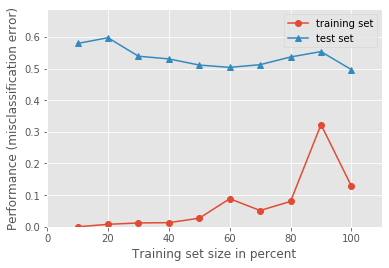

In [74]:
from sklearn.model_selection import cross_val_score, train_test_split
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(Xf_rus, yf_rus, test_size=0.3, random_state=0)
boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=10, algorithm='SAMME')
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, boosting, print_model=False, style='ggplot')
plt.show()

## Stacking in ensemble learning
Stacking is an ensemble learning technique that combines multiple classification or regression models via a
meta-classifier or a meta-regressor. The base level models are trained based on complete training set then the
meta-model is trained on the outputs of base level model as features. The base level often consists of different
learning algorithms and therefore stacking ensembles are often heterogeneous.

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [76]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
# clf4 = SGDClassifier(loss='hinge', max_iter=100)
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
meta_classifier=lr)

In [77]:
# Converting sentiments to integers to plot graphs
X_array = Xf_rus.toarray()


yf_rus[yf_rus == 'positive'] = 1
yf_rus[yf_rus == 'negative'] = 0
yf_rus[yf_rus == 'neutral'] = 2
yf_rus=yf_rus.astype('int')

In [78]:
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)
clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
    scores = cross_val_score(clf, X_array, yf_rus, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

Accuracy: 0.44 (+/- 0.01) [KNN]
Accuracy: 0.34 (+/- 0.02) [Random Forest]
Accuracy: 0.45 (+/- 0.03) [Naive Bayes]
Accuracy: 0.43 (+/- 0.01) [Stacking Classifier]
